In [8]:
import deepxde as dde
import numpy as np
import torch
from sklearn import preprocessing
import time

In [16]:
# Import PointSetBC for specifying boundary conditions at arbitrary points
from deepxde.icbc import PointSetBC

# Load and preprocess data #################################################################################################

# Load displacement coordinate data (positions where displacements are measured)
x_disp = np.loadtxt('data_incompressible/m_rose_nu_05/disp_coord')

# Load displacement data corresponding to x_disp (measured ux and uy displacements)
y_disp = np.loadtxt('data_incompressible/m_rose_nu_05/disp_data')  # ux, uy displacement data

# Load strain coordinate data (positions where strains are measured)
x_strain = np.loadtxt('data_incompressible/m_rose_nu_05/strain_coord')

# Load strain data corresponding to x_strain (measured strains)
y_strain = np.loadtxt('data_incompressible/m_rose_nu_05/strain_data')

# Load known Young's modulus values (material property E)
m_data = np.loadtxt('data_incompressible/m_rose_nu_05/m_data')  # Known Young's modulus values

# Load known Poisson's ratio values (material property ν)
nu_data = np.loadtxt('data_incompressible/m_rose_nu_05/nu_data')  # Known Poisson's ratio values

# Check for NaNs in input data to ensure data integrity####################################################################

print("NaNs in x_disp:", np.isnan(x_disp).any())      # Check for NaNs in displacement coordinates
print("NaNs in y_disp:", np.isnan(y_disp).any())      # Check for NaNs in displacement data
print("NaNs in x_strain:", np.isnan(x_strain).any())  # Check for NaNs in strain coordinates
print("NaNs in y_strain:", np.isnan(y_strain).any())  # Check for NaNs in strain data
print("NaNs in m_data:", np.isnan(m_data).any())      # Check for NaNs in Young's modulus data
print("NaNs in nu_data:", np.isnan(nu_data).any())    # Check for NaNs in Poisson's ratio data

# Normalize coordinates to improve numerical stability during training ####################################################

# Create a StandardScaler object for normalizing coordinate data
ss_x = preprocessing.StandardScaler()

# Fit the scaler to x_disp and transform x_disp to have zero mean and unit variance
x_disp_norm = ss_x.fit_transform(x_disp)

# Use the same scaler to transform x_strain (ensuring consistent scaling)
x_strain_norm = ss_x.transform(x_strain)

# Combine all normalized coordinate data to find global minimum and maximum values

# Stack normalized displacement and strain coordinates vertically
all_coords = np.vstack((x_disp_norm, x_strain_norm))

# Find global minimum x and y values across all coordinates
x_min, y_min = np.min(all_coords, axis=0)

# Find global maximum x and y values across all coordinates
x_max, y_max = np.max(all_coords, axis=0)

# Geometry setup (assuming a 2D rectangular domain)#########################################################################

# Define the computational geometry as a rectangle from [x_min, y_min] to [x_max, y_max]
geom = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])

# Define the PDE residuals for the inverse problem using DeepXDE's automatic differentiation###############################

def pde_inverse(x, u):
    """
    Defines the PDE residuals for the inverse problem of identifying material properties.

    Parameters:
    x : array-like
        Input coordinates (batch_size x 2), where each row is [x, y].
    u : array-like
        Predicted outputs (batch_size x 4), where columns are [E_pred, nu_pred, ux_pred, uy_pred].

    Returns:
    list of tensors
        Residuals of the equilibrium equations to be minimized.
    """
    # Extract predicted Young's modulus (E), Poisson's ratio (ν), and displacements (ux, uy)
    E_pred = u[:, 0:1]     # Predicted Young's modulus at each point
    nu_pred = u[:, 1:2]    # Predicted Poisson's ratio at each point
    ux_pred = u[:, 2:3]    # Predicted displacement in x-direction
    uy_pred = u[:, 3:4]    # Predicted displacement in y-direction

    # Add epsilon to prevent division by zero or invalid values in Poisson's ratio
    epsilon = 1e-6

    # Clamp Poisson's ratio to a valid range [epsilon, 0.5 - epsilon] to ensure physical realism
    nu_pred = torch.clamp(nu_pred, min=epsilon, max=0.5 - epsilon)

    # Compute derivatives of displacements with respect to spatial coordinates (strain components)

    # Compute ∂ux/∂x (normal strain in x)
    ux_x = dde.grad.jacobian(ux_pred, x, i=0, j=0)

    # Compute ∂ux/∂y (shear strain)
    ux_y = dde.grad.jacobian(ux_pred, x, i=0, j=1)

    # Compute ∂uy/∂x (shear strain)
    uy_x = dde.grad.jacobian(uy_pred, x, i=0, j=0)

    # Compute ∂uy/∂y (normal strain in y)
    uy_y = dde.grad.jacobian(uy_pred, x, i=0, j=1)

    # Stress tensor relations based on linear elasticity theory

    # Compute σ_xx = E * (∂ux/∂x + ν * ∂uy/∂y)
    sigma_xx = E_pred * (ux_x + nu_pred * uy_y)

    # Compute σ_yy = E * (∂uy/∂y + ν * ∂ux/∂x)
    sigma_yy = E_pred * (uy_y + nu_pred * ux_x)

    # Compute τ_xy = [E / (2 * (1 + ν))] * (∂ux/∂y + ∂uy/∂x)
    # Add epsilon to denominator to avoid division by zero when ν approaches -1
    tau_xy = E_pred * (ux_y + uy_x) / (2 * (1 + nu_pred + epsilon))

    # Residuals for equilibrium equations (static equilibrium with no body forces)

    # Compute ∂σ_xx/∂x + ∂τ_xy/∂y = 0 (equilibrium in x-direction)
    res_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0) + dde.grad.jacobian(tau_xy, x, i=0, j=1)

    # Compute ∂σ_yy/∂y + ∂τ_xy/∂x = 0 (equilibrium in y-direction)
    res_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1) + dde.grad.jacobian(tau_xy, x, i=0, j=0)

    # Return the residuals; the goal is to minimize these during training
    return [res_x, res_y]

# Define boundary conditions using observed displacement data with PointSetBC###############################################

# Enforce that predicted ux at measurement points equals observed ux data (component index 2 corresponds to ux_pred)
bc_disp_ux = PointSetBC(x_disp_norm, y_disp[:, 0:1], component=2)

# Enforce that predicted uy at measurement points equals observed uy data (component index 3 corresponds to uy_pred)
bc_disp_uy = PointSetBC(x_disp_norm, y_disp[:, 1:2], component=3)

# Adjust model parameters for faster training (e.g., for testing or demonstration purposes)################################

# Number of random points inside the domain for PDE residual computation
num_domain = 2000

# Number of points on the boundary (not used here since we use PointSetBC)
num_boundary = 100

# Define the neural network architecture: input layer + hidden layers + output layer
# For a 2D problem with 2 inputs (x and y), 2 hidden layers of 64 neurons each, and 4 outputs##############################
layer_size = [2] + [64] * 2 + [4]  # Smaller network for faster computation

# Data setup for training using the PDE and boundary conditions############################################################

data = dde.data.PDE(
    geom,                      # Geometric domain of the problem
    pde_inverse,               # PDE residual function defined earlier
    [bc_disp_ux, bc_disp_uy],  # Boundary conditions using displacement data
    num_domain=num_domain,     # Number of domain points for PDE residuals
    num_boundary=num_boundary, # Number of boundary points (unused here)
)

# Define the neural network architecture using DeepXDE's feedforward neural network (FNN)###################################

# Specify activation function and initializer for the neural network
activation = "tanh"          # Hyperbolic tangent activation function
initializer = "Glorot uniform"  # Weight initializer

# Create the neural network with the specified layer sizes, activation function, and initializer
net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition and compilation with a smaller learning rate for numerical stability#####################################

# Combine the data and neural network into a DeepXDE Model
model = dde.Model(data, net)

# Compile the model using the Adam optimizer with a learning rate of 0.0005
model.compile("adam", lr=0.0005)

# Start the timer to measure the training duration
start_time = time.time()

# Train the model for a few iterations to test speed and verify setup#######################################################

# Train the model for 50 iterations (epochs), displaying progress every 2 iterations
losshistory, train_state = model.train(iterations=50, display_every=2)

# Predicting values for E_pred and nu_pred at the strain coordinate points after training

# Use the trained model to predict outputs at x_strain_norm
# The model predicts [E_pred, nu_pred, ux_pred, uy_pred]; extract E_pred and nu_pred

# Extract predicted Young's modulus (E) at strain measurement points
E_pred = model.predict(x_strain_norm)[:, 0]  # Estimated Young's modulus

# Extract predicted Poisson's ratio (ν) at strain measurement points
nu_pred = model.predict(x_strain_norm)[:, 1]  # Estimated Poisson's ratio

# Save predicted values to text files for further analysis or visualization

np.savetxt('E_pred_inverse', E_pred)      # Save E_pred to 'E_pred_inverse' file
np.savetxt('nu_pred_inverse', nu_pred)    # Save nu_pred to 'nu_pred_inverse' file

# Calculate and print the total elapsed time for training and prediction####################################################

print("--- %s Elapsed time ---" % (time.time() - start_time))



NaNs in x_disp: False
NaNs in y_disp: False
NaNs in x_strain: False
NaNs in y_strain: False
NaNs in m_data: False
NaNs in nu_data: False
Compiling model...
'compile' took 0.000162 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.61e-05, 1.42e-03, 2.29e+00, 1.01e+00]    [5.61e-05, 1.42e-03, 2.29e+00, 1.01e+00]    []  
2         [6.93e-05, 7.37e-04, 2.15e+00, 9.14e-01]    [6.93e-05, 7.37e-04, 2.15e+00, 9.14e-01]    []  
4         [1.02e-04, 3.86e-04, 2.03e+00, 8.27e-01]    [1.02e-04, 3.86e-04, 2.03e+00, 8.27e-01]    []  
6         [1.52e-04, 2.93e-04, 1.91e+00, 7.53e-01]    [1.52e-04, 2.93e-04, 1.91e+00, 7.53e-01]    []  
8         [2.16e-04, 3.85e-04, 1.80e+00, 6.89e-01]    [2.16e-04, 3.85e-04, 1.80e+00, 6.89e-01]    []  
10        [2.93e-04, 6.01e-04, 1.70e+00, 6.35e-01]    [2.93e-04, 6.01e-04, 1.70e+00, 6.35e-01]    []  
12        [3.78e-04, 8.73e-04, 1.61e+00, 5.89e-01]    [3.78e-04, 8.73e

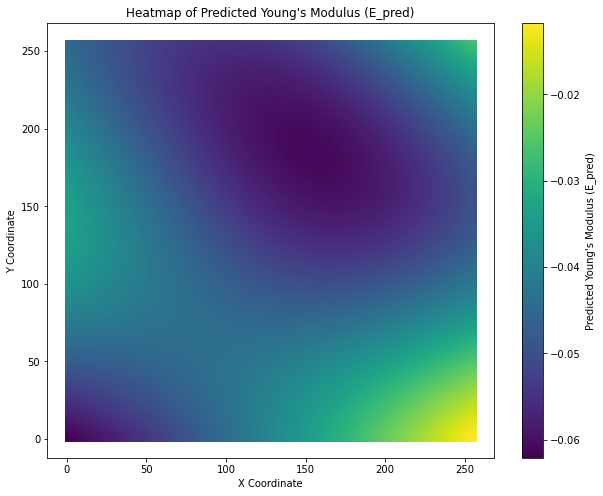

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Load or use your existing data for E_pred and coordinates
# x_strain_norm contains the normalized coordinates for the predicted E values
x_strain_norm = np.loadtxt('data_incompressible/m_rose_nu_05/strain_coord')  # Assuming it is normalized already
E_pred = np.loadtxt('E_pred_inverse')  # Predicted Young's modulus

# Reshape or adjust if necessary
x_coords = x_strain_norm[:, 0]
y_coords = x_strain_norm[:, 1]

# Plotting E_pred as a heatmap or scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, c=E_pred, cmap='viridis', marker='s')
plt.colorbar(label="Predicted Young's Modulus (E_pred)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Heatmap of Predicted Young's Modulus (E_pred)")
plt.show()



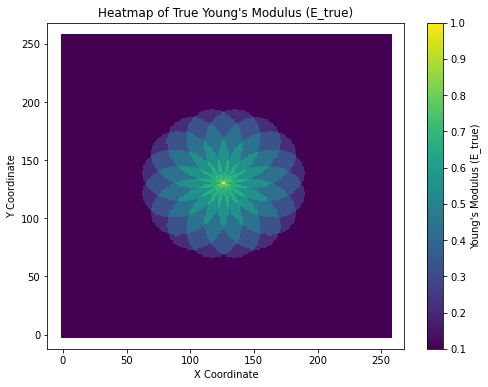

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load or preprocess your data (adjust paths if needed)
x_strain = np.loadtxt('data_incompressible/m_rose_nu_05/strain_coord')  # Coordinates
E_true = np.loadtxt('data_incompressible/m_rose_nu_05/m_data')          # True Young's modulus values

# Reshape or interpolate data for heatmap plotting if needed
# Assuming x_strain has shape (N, 2) where each row is [x, y] coordinate,
# and E_true has shape (N, 1) or (N, ) corresponding to each coordinate
x_coords = x_strain[:, 0]
y_coords = x_strain[:, 1]

# Set up the grid for plotting the heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=E_true, cmap='viridis', marker='s')
plt.colorbar(label="Young's Modulus (E_true)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Heatmap of True Young's Modulus (E_true)")
plt.show()
